In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
from reldresal import *

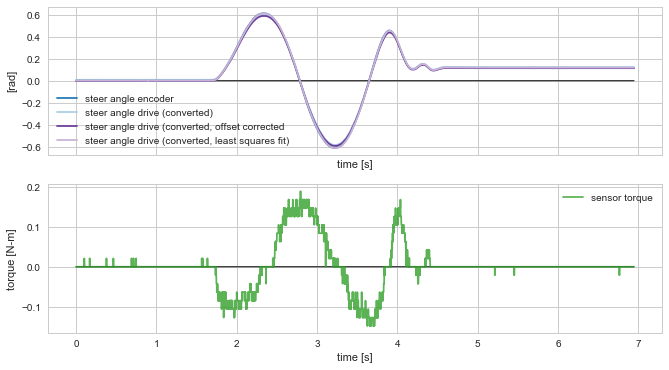

(<matplotlib.figure.Figure at 0x110281b70>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1105ac7f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11060fac8>], dtype=object))

In [3]:
data1 = load_log('no_mass_no_spring.log.gz')
plot_log(data1)

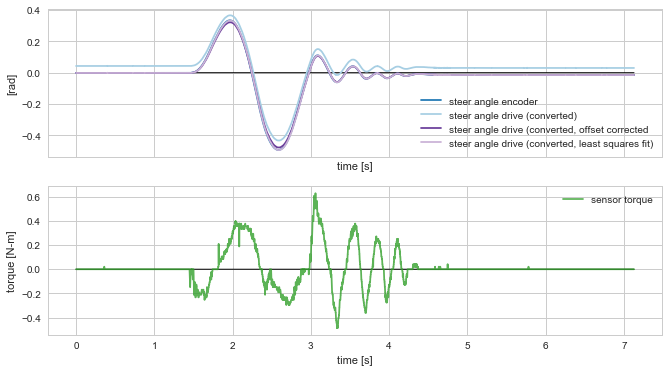

(<matplotlib.figure.Figure at 0x10636d6d8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11054a6d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113a8df98>], dtype=object))

In [4]:
data2 = load_log('mass_no_spring.log.gz')
plot_log(data2)

In [5]:
savgol_width = 111
savgol_polyorder = 5

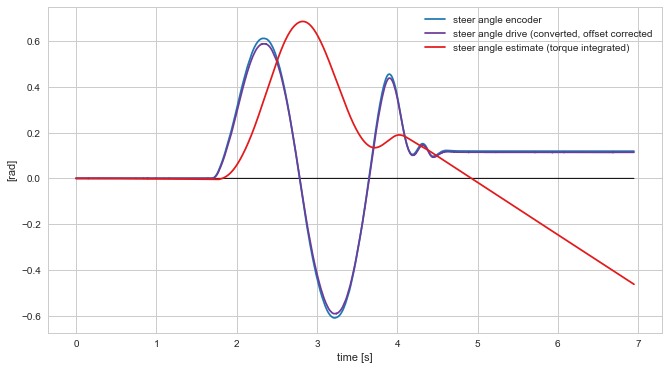

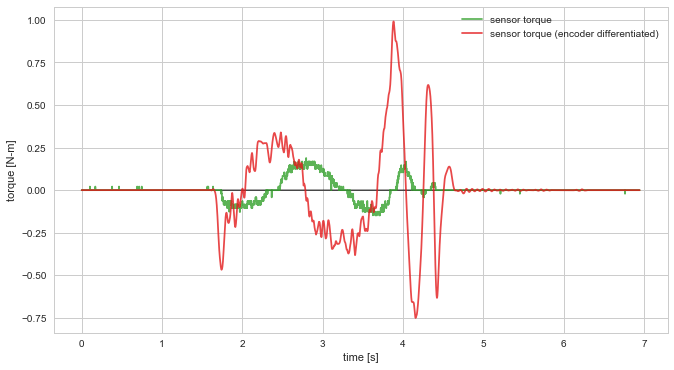

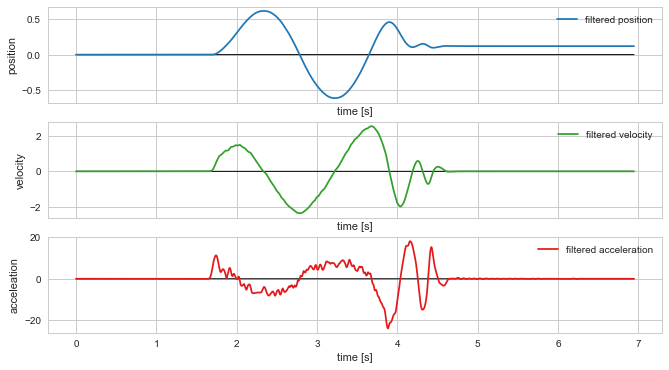

(<matplotlib.figure.Figure at 0x113d21c88>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x113d2e518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113db8a58>], dtype=object))

In [6]:
# For record 1, we use the measured inertia values:
# https://drive.google.com/file/d/0B0TYqj2SzQN5dWlyNDFIb0FKd0k/view
# 
m0 = 0.0413
m1 = 0.0828 - m0
plot_integrated_torque(data1, m1)
plot_differentiated_position(data1, m1,
                             savgol_width, savgol_polyorder)
plot_savgol_derivatives(data1, savgol_width, savgol_polyorder)

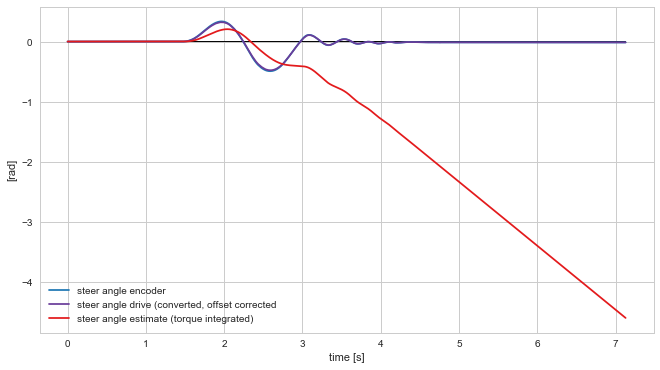

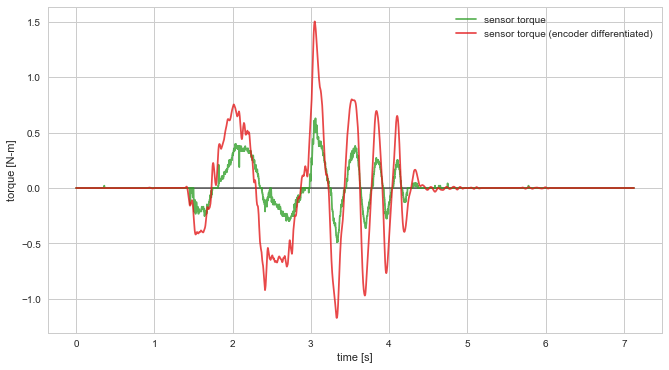

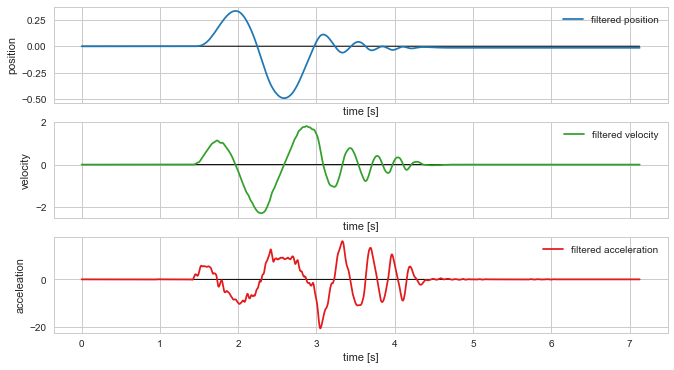

(<matplotlib.figure.Figure at 0x113ac54a8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x113a3d908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1142f3f60>], dtype=object))

In [7]:
# Record has two mass plates of 1 kg located roughly 0.126 m from the shaft center
disc_weight_inertia = 2*(1)*(0.126)**2
plot_integrated_torque(data2, m1 + disc_weight_inertia)
plot_differentiated_position(data2, m1 + disc_weight_inertia,
                             savgol_width, savgol_polyorder)
plot_savgol_derivatives(data2, savgol_width, savgol_polyorder)

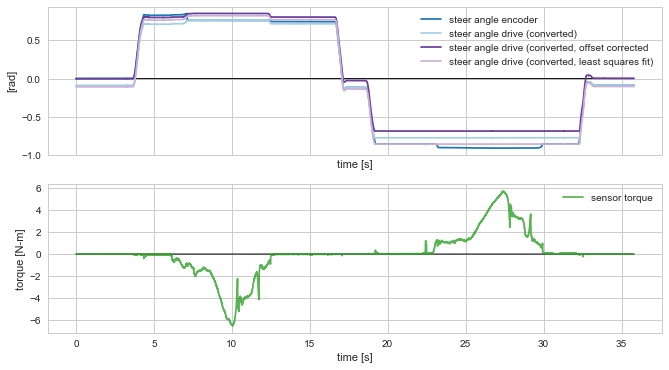

(<matplotlib.figure.Figure at 0x114500208>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x113dc15f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113a50160>], dtype=object))

In [8]:
data5 = load_log('torque_7nm.log.gz')
plot_log(data5)

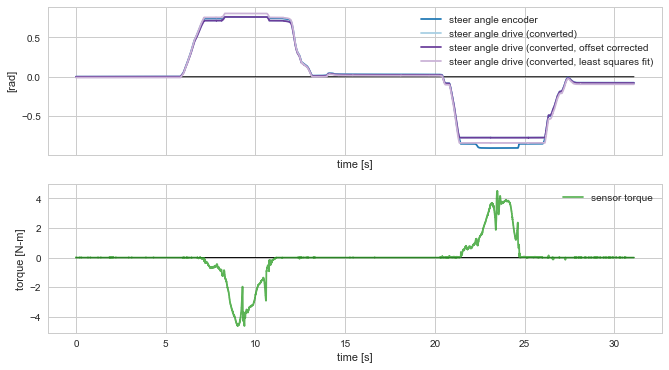

(<matplotlib.figure.Figure at 0x113a08358>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x113a5c630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115b63c88>], dtype=object))

In [9]:
data6 = load_log('torque_5nm.log.gz')
plot_log(data6)

[-6.36141222, -4.2358599, 0, 4.102296750000001, 6.24679218]
[-6.5325800000000003, -4.6298899999999996, 0, 3.89, 5.7018199999999997]


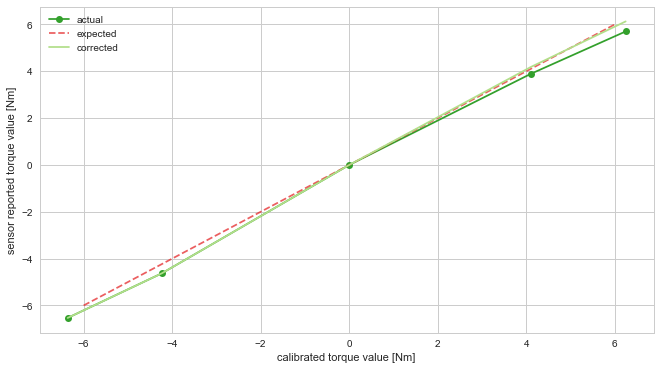

In [10]:
# torque wrench values calculated using
# mass plates and distance measurement
colors = sns.color_palette('Paired', 10)

g = 9.81
t_calibration = [-2.921*g*0.222, -1.945*g*0.222, 0, 1.945*g*0.215, 2.921*g*0.218]
t_sensor = [np.min(data5.kistler_torque),
            np.min(data6.kistler_torque),
            0,
            3.89, #np.max(data6.kistler_torque),
            np.max(data5.kistler_torque)]
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(t_calibration, t_sensor, color=colors[3],
        marker='o',
        label='actual')
ax.plot([-6, 6], [-6, 6], color=colors[5], alpha=0.7,
        linestyle='--',
        label='expected')

print(t_calibration)
print(t_sensor)
scale = np.array([t_calibration[i]/t_sensor[i] for i in [-1, -2]])
# scale torque sensor measurements if
# value is greater than zero
t = [elem*scale.mean() if elem > 0 else elem
     for elem in t_sensor]
ax.plot(t_calibration, t, color=colors[2],
        label='corrected')

ax.set_xlabel('calibrated torque value [Nm]')
ax.set_ylabel('sensor reported torque value [Nm]')
ax.legend()

In [11]:
def rescale_torque(record):
    # apply rescaling for measured positive sensor torques
    torque = -np.array(
        [x*scale.mean() if x > 0 else x
         for x in record.kistler_torque]).reshape((-1, 1))
    return torque

def sg_filter(record, deriv):
    x = scipy.signal.savgol_filter(
        record.steer_angle, savgol_width, savgol_polyorder,
        deriv=deriv, delta=np.mean(np.diff(record.time)[:-1]),
        mode='nearest').reshape((-1, 1))
    return x

# estimate inertia, damping of lower mass by least squares
# T = m*x_dd + b*x_d
# T = [x_dd, x_d] [m, b]'
def estimate_mb(record):
    torque = rescale_torque(record)
    velocity = sg_filter(record, 1)
    acceleration = sg_filter(record, 2)
    A = np.hstack((acceleration, velocity))
    return np.squeeze(np.linalg.lstsq(A, torque)[0])

def mb_func(x, t, p):
    """
    x: vector of state variables [pos, vel]
    t: time
    p: 4-tuple of (mass, damping, sample period, list of sampled torque)
    """
    pos, vel = x
    m, b, dt, tau = p
    if t < 0:
        t = 0
    if t > dt*(len(tau) - 1):
        t = dt*(len(tau) - 1)
    acc = -b/m*vel + 1/m*tau[int(round(t/dt))]
    return [vel, acc]

def integrate_torque(record, m, b):
    torque = rescale_torque(record)
    dt = np.mean(np.diff(record.time))
    soln = scipy.integrate.odeint(
        mb_func, [0, 0], record.time, args=((m, b, dt, torque),))
    return soln[:, 0]
    
def plot_estimates(record):
    m, b = estimate_mb(record)
    print('estimated inertia:', m)
    print('estimated viscous damping:', b)
    
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)
    torque = rescale_torque(record)
    veloc = sg_filter(record, 1)
    accel = sg_filter(record, 2)
    ax[0].plot(record.time, torque, color=colors[3],
               alpha=0.8,
               label='sensor torque')
    ax[0].plot(record.time, m*accel, color=colors[4],
               alpha=0.8,
               label='inertia torque')
    ax[0].plot(record.time, b*veloc, color=colors[6],
               alpha=0.8,
               label='damping torque')
    ax[0].plot(record.time, m*accel + b*veloc, color=colors[2],
               alpha=0.8,
               label='sum inertia and damping torque')
    ax[0].legend()
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('torque [N-m]')
    ax[0].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    
    ax[1].plot(record.time, record.steer_angle, color=colors[1],
              label='steer angle encoder')
    ax[1].plot(record.time, integrate_torque(record, m, b), color=colors[0],
              label='steer angle estimate from integrated torque')
    ax[1].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    ax[1].legend()
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('position [rad]')
    plt.show()

estimated inertia: 0.0276449809356
estimated viscous damping: 0.0796821882618


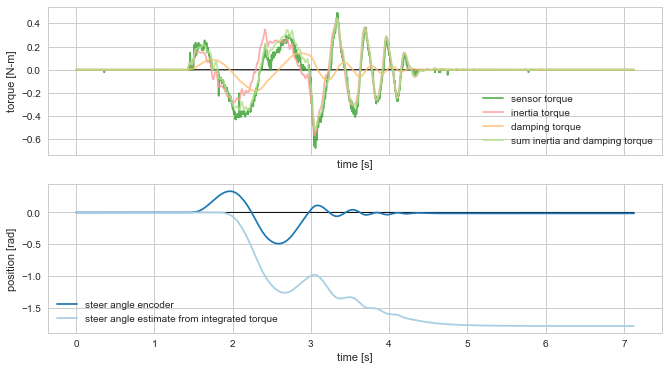

In [12]:
plot_estimates(data2)

estimated inertia: 0.000331802014192
estimated viscous damping: 0.0626362152351


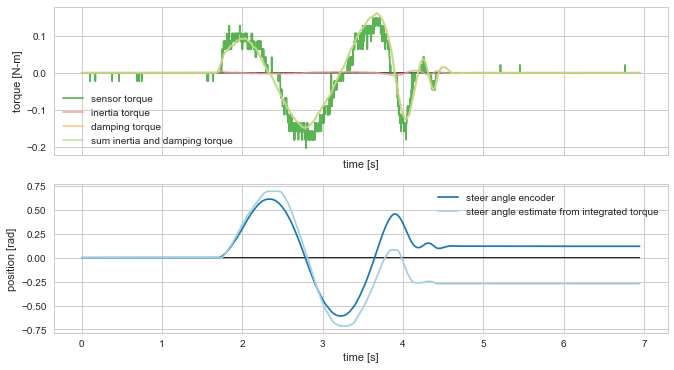

In [13]:
plot_estimates(data1)